In [1]:
from udep2mono import polarization
from polarization import run_polarize_pipeline
import networkx as nx
import matplotlib.pyplot as plt
import binarytree as bt
from wordnet import find_relation, get_word_sets

2020-12-22 12:12:54 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-12-22 12:12:54 INFO: Use device: gpu
2020-12-22 12:12:54 INFO: Loading: tokenize
2020-12-22 12:12:57 INFO: Loading: pos
2020-12-22 12:12:58 INFO: Loading: lemma
2020-12-22 12:12:58 INFO: Loading: depparse
2020-12-22 12:12:59 INFO: Loading: sentiment
2020-12-22 12:13:00 INFO: Loading: ner
2020-12-22 12:13:01 INFO: Done loading processors!
2020-12-22 12:13:03 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-12-22 12:13:03 INFO: Use device: gpu
2020-12-22 12:13:03 INFO: Loading: tokenize
2

In [222]:
#G = Ugraph()
nounModifiers = {"det", "nummod", "amod","obl:tmod", "acl:relcl"}
verbModifiers = {"advmod"}
nounCategories = {"compound"}
verbs = {"VBZ", "VBP", "VBD"}
modified = {"NN", "JJ"}.union(verbs)
modifiers = nounModifiers.union(verbModifiers)
contents = {"nsubj","obj","cop","compound"}
cont_npos = {"nsubj":'nn', "obj": 'nn', "cop": 'vbz', "verb": 'vbz'}
mark_toProp = {"+": {"hyponym","synonym"}, "-": {"hypernym","synonym"}, "=": {"synonym"}}
clause_prop = {"which", "that", "who"}
be_verbs = {"is", "am", "are", "be"}

In [223]:
#G.add_node("ok",id=1)
#G.add_node("fine")

In [224]:
#nx.draw(G, with_labels=True)
sentenceset = ["This are 2 specially cool dog food", "Animal cut fresh meat carefully every month"]
test1 = ["A lady cuts some meat", "A woman cuts some meat"]
testWhich = ["a lady who is beautiful drives a car, that is old ", "A beautiful woman drives a old car"]
test2 = ["A dog is eating food", "A dog is blue"] 
#det order
#add word/modifier
#"and" in connection 

In [225]:
results = run_polarize_pipeline(testWhich)[0]
print(results)

100%|██████████| 2/2 [00:02<00:00,  1.09s/it][('a↑ lady↑ who↑ is↑ beautiful↑ drives↑ a↑ car↑ that↑ is= old=', 'a lady who is beautiful drives a car, that is old ', '[nsubj↑ [det↑ [DT a↑] [acl:relcl↑ [nsubj↑ [WP who↑] [obj↑ [det↑ [DT a↑] [NN car↑]] [VBZ drives↑]]] [acl:relcl↑ [cop↑ [VBZ is↑] [JJ beautiful↑]] [NN lady↑]]]] [nsubj↑ [DT that↑] [cop= [VBZ is=] [JJ old=]]]]', [(1, 'DT'), (2, 'NN'), (4, 'VBZ'), (3, 'WP'), (6, 'VBZ'), (7, 'DT'), (5, 'JJ'), (8, 'NN'), (10, 'DT'), (11, 'VBZ'), (12, 'JJ')], <binarization.BinaryDependencyTree object at 0x000001EF2A0AC708>), ('a↑ beautiful↑ woman↑ drives↑ a↑ old↑ car↑', 'A beautiful woman drives a old car', '[nsubj↑ [det↑ [DT a↑] [amod↑ [JJ beautiful↑] [NN woman↑]]] [obj↑ [det↑ [DT a↑] [amod↑ [JJ old↑] [NN car↑]]] [VBZ drives↑]]]', [(1, 'DT'), (2, 'JJ'), (3, 'NN'), (5, 'DT'), (6, 'JJ'), (7, 'NN'), (4, 'VBZ')], <binarization.BinaryDependencyTree object at 0x000001EF2B722348>)]



In [226]:
class Unode:
    def __init__(self,prop,word,npos, mark):
        self.nexts = dict()
        self.prop = prop
        self.isRoot = False
        self.nexts["all"] = set()
        self.word = word
        self.npos = npos
        self.mark = mark
    def add_Unode(self, node):
        #print(node.prop)
        if(self.isRoot):
            self.nexts[node.prop] = node
        else:
            self.nexts["all"].add(node)
    def get_inText(self, index):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                if(key != "all"):
                    print(key)
                    connected_info += (key + ": " + self.nexts[key].get_inText(index + 1) + " ")
            return "{ " + connected_info + "}"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    print("111")
                    connected_info += node.get_inText(index + 1)
            return "{ The " + str(index) + " layer" + ": " + self.word + connected_info + "}"


In [227]:
class Ugraph:
    def __init__(self, rootNode):
        self.root = rootNode
        self.root.isRoot = True
        self.root.nexts.pop("all",None)
        self.nodes = set()
        self.contentSet = set()
    def add_node(self,node):
        self.nodes.add(node)
    def add_edge(self, node1, node2):
        if(node1.isRoot):
            self.contentSet.add(node2.word)
        node1.add_Unode(node2)
    def contains(self, word_assigned):
        return word_assigned in self.contentSet

In [228]:
def print_as_graph(tree):
    G = nx.DiGraph()
    construct_treeGraph(tree,G)
    #G.add_node("this",id=2)
    nx.draw_planar(G, with_labels=True)

In [229]:
def print_tree_simple(tree):
    if(tree == "N"):
        return bt.Node("Not a Tree")
    root = bt.Node(tree.val)
    construct_tree(tree, root)
    print(root)

In [230]:
def construct_treeGraph(tree,G):
    if(tree == "N"):
        return
    else:
        if(tree.left != "N"):
            
            G.add_node(tree.left.val,id=1)
            G.add_edge(tree.val, tree.left.val)
            construct_treeGraph(tree.left,G)
        if(tree.right != "N"):
            #print(tree.right.npos==None)
            G.add_node(tree.right.val,id=1)
            G.add_edge(tree.val, tree.right.val)
            construct_treeGraph(tree.right,G)

In [231]:
def construct_tree(tree, subtree):
    if(tree == "N"):
        return
    if(tree.left != "N"):
        subtree.left = bt.Node(tree.left.val)
        construct_tree(tree.left, subtree.left)
    if(tree.right != "N"):
        subtree.right = bt.Node(tree.right.val)
        construct_tree(tree.right, subtree.right)
    

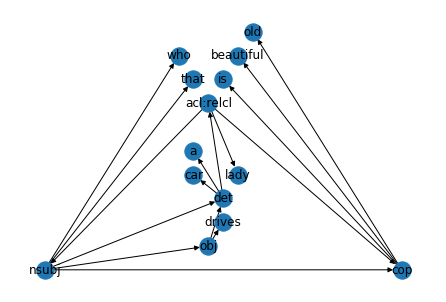

In [232]:
print_as_graph(results[0][4])
#print_tree_simple(results[0][4])

In [233]:
class graph_Info():
    def __init__(self,graph,crucials):
        self.graph = graph
        self.crucials = crucials

In [234]:
def mono2Graph(sent_info):
    G = Ugraph(Unode("root", "Root","r00t","="))
    #extract_NOV(sent_info, G)
    #print(G.root.nexts)
    #print(sent_info)
    mono2Graph_recur(sent_info, G, set()) ### root directly assigned for test here
    return G

In [235]:
def printUgraph_inText(Ugraph):
    print(Ugraph.root.get_inText(1))

In [236]:
G = mono2Graph(results[0][4])
printUgraph_inText(G)
print(len(G.nodes))
for node_p in G.nodes:
    print(node_p.word+ "222")
print(G.root.nexts.keys())

Error occured in concentrating contents
nsubj
111
verb
obj
111
nsubj
obj
111
verb
111
verb
obj
{ nsubj: { The 2 layer: lady{ verb: { The 4 layer: is} obj: { The 4 layer: beautiful} }{ nsubj: { The 4 layer: who} obj: { The 4 layer: car{ The 5 layer: a}} verb: { The 4 layer: drives} }{ The 3 layer: a}} verb: { The 2 layer: is} obj: { The 2 layer: old} }
5
a222
that222
is222
old222
lady222
dict_keys(['nsubj', 'verb', 'obj'])


In [237]:
# def extract_NOV(sent, G):
#     if(sent == "N"):
#         return
#     #print(sent.npos)
#     if((sent.val in contents or sent.npos in verbs) and not(sent.val in G.root.nexts.keys())):
#         print(sent.npos)
#         if sent.npos in verbs and sent.parent.val not in {"cop"}:
#             tempNode = Unode("verb", sent.val)
#         else:
#             if (sent != "N"):
#                 print(sent.val)
#             else:
#                 print(sent)
#             currentNode = sent.left
#             while(currentNode.right != "N"):
#                 currentNode = currentNode.right
#             tempNode = Unode(sent.val,currentNode.val)
#             G.add_node(tempNode)
#             G.add_edge(G.root, tempNode)
#             if(sent.val == "cop"):
#                 currentNode = sent.right
#                 while(currentNode.right != "N"):
#                     if(currentNode.val == "compound"):
#                         tempNode1 = Unode("obj",currentNode.left.val + " " + currentNode.right.val)
#                         G.add_node(tempNode1)
#                         G.add_edge(G.root, tempNode1)
#                         return
#                     currentNode = currentNode.right
#                 tempNode1 = Unode(sent.val,currentNode.val)
#                 G.add_node(tempNode1)
#                 G.add_edge(G.root, tempNode1)
        
#     #if(sent.val == "obj"):
#         #extract_NOV(sent.left, G)
#     extract_NOV(sent.right, G)

In [238]:
def mono2Graph_recur(sent_tree, G, mods, pos = None):
    needleft = True
    needright = True
    if(sent_tree == "N"):
        return
    #print(sent_tree.val)
    # 
    #if(sent_tree.nposif(sent_tree.val == "compound"):
    #         compound_out = sent_tree.left.val+" " + sent_tree.right.val
    #         G.add_node(compound_out)
    #         G.add_edge(root,compound_out)
    #         #ls.append(compound_out)
            
    #         return != None):
        #print(sent_tree.val + " " + sent_tree.parent.val)
        # if((sent_tree.npos in modified and sent_tree.npos != "JJ") or (sent_tree.parent!= "N" and sent_tree.parent.val == "nsubj")):
        #     ls.append(sent_tree.val)
        #     #G.add_node(sent_tree.val)
        #     G.add_node(sent_tree.parent.val,name=sent_tree.val)
        #     G.add_edge(root, sent_tree.parent.val)
        #     #G.add_edge(sent_tree.parent.val, sent_tree.val)
    #    print("")
    else:
        #print(sent_tree.val)
        if(sent_tree.val in modifiers):
            if(sent_tree.val == "acl:relcl"):
                G_prime = mono2Graph(sent_tree.left)
                mods.add(G_prime.root)
            else:
                mods.add(mono2Graph_recur(sent_tree.left, G, set(), sent_tree.val))
            #print("000000000")
            #for item_print in mods:
            #    if(item_print!=None):
            #        print(item_print.word)
            #print("000000000")
            return mono2Graph_recur(sent_tree.right, G, mods, pos)            
        else:
            if ((sent_tree.left == "N" and sent_tree.right == "N") or sent_tree.val == "compound" ):
                    if(sent_tree.val == "compound"):
                        newNode = Unode(pos, sent_tree.left.val + " " + sent_tree.right.val,                                                        sent_tree.npos, sent_tree.mark)
                    else:
                        newNode = Unode(pos, sent_tree.val, sent_tree.npos, sent_tree.mark)
                    G.add_node(newNode)
                    if (sent_tree.npos in modified or pos in contents or pos == "verb"):
                        if(pos in contents or pos == "verb"):
                            if(pos in G.root.nexts.keys()):
                                print("Error occured in concentrating contents")
                            else:
                                G.root.nexts[pos] = newNode
                        for node in mods:
                            #if(G.contains(sent_tree.val)):
                                # loc = ""
                                # if(sent_tree.npos in verbs):
                                #     loc = "verb"
                                # else:
                                #     for key_cont in G.root.nexts.keys():
                                #         if(key_cont != "all"):
                                #             if(G.root.nexts[key_cont].word == sent_tree.val):
                                #                 loc = key_cont
                                #                 break
                                G.add_edge(newNode, node)
                        return newNode
                    else:
                        mods.add(newNode)
                        return newNode
            else: 
                if(sent_tree.val in contents):
                    pos_left = sent_tree.val
                    pos_right = pos
                    if(sent_tree.val == "nsubj"):
                        pos_right = "verb"
                    if(sent_tree.val == "cop"):
                        pos_left = "verb"
                        pos_right = "obj"
                    mono2Graph_recur(sent_tree.left, G,set(),pos_left)
                    mono2Graph_recur(sent_tree.right, G, mods, pos_right)
    #if(needleft):
    #    mono2Graph_recur(sent_tree.left, G, mods)
    #if(needright):
    #    mono2Graph_recur(sent_tree.right, G, mods)

In [239]:
#def mono2Graph_categorize(sent_tree, G, root):
    

In [240]:
# def find_nearest_belongTo(sent_tree, G, content_mark):
#     if(sent_tree == "N"):
#         print("Seems to have a parsing or binarization error")
#         return "", -2
#     if(sent_tree.npos == None):
#         if(sent_tree.val == "compound"):
#             comp_node = sent_tree.left.val + " " + sent_tree.right.val
#             if(comp_node in G.['dict'].keys()):
#                 print(comp_node)
#                 #G.nodes["C1"]['dict'].update({comp_node: content_mark})

#             return sent_tree, 2
#         return find_nearest_belongTo(sent_tree.right,G,content_mark)

#     elif (sent_tree.npos in modified or sent_tree.val in {"this", "these", "there", "that"} ):
#         if(sent_tree.parent.val in contents):
#             key = sent_tree.val
#             #print(sent_tree.val)
#             G.nodes["C1"]['dict'].update({key: sent_tree.parent.val})
#         return sent_tree, 1
#     else: 
#         print(sent_tree.val)
#         return "", -1

In [241]:
#graph_out1 = mono2Graph(results[0])
#graph_out2 = mono2Graph(results[0])
#print(graph_out2.graph.nodes['obl:tmod'])
#nx.draw(graph_out2.graph, with_labels=True,center="C1")

In [242]:
"compound" == ("a" or "compound" )

False

In [243]:
G1 = mono2Graph(results[0][4])
G2 = mono2Graph(results[1][4])
printUgraph_inText(G1)
printUgraph_inText(G2)
print(G.root.nexts.keys())

Error occured in concentrating contents
nsubj
111
nsubj
obj
111
verb
111
verb
obj
111
verb
obj
{ nsubj: { The 2 layer: lady{ nsubj: { The 4 layer: who} obj: { The 4 layer: car{ The 5 layer: a}} verb: { The 4 layer: drives} }{ verb: { The 4 layer: is} obj: { The 4 layer: beautiful} }{ The 3 layer: a}} verb: { The 2 layer: is} obj: { The 2 layer: old} }
nsubj
111
111
obj
111
111
verb
{ nsubj: { The 2 layer: woman{ The 3 layer: a}{ The 3 layer: beautiful}} obj: { The 2 layer: car{ The 3 layer: old}{ The 3 layer: a}} verb: { The 2 layer: drives} }
dict_keys(['nsubj', 'verb', 'obj'])


In [244]:
def check_alignment(graph1, graph2):
    return check_alignByRoot(graph1.root, graph2.root)

In [245]:
def check_alignByRoot(root1, root2):
    for cont in {"nsubj", "verb", "obj"}:
        if(not(check_cont(root1, root2, cont))):
            print(cont)
            return "UnAligned"
    return "Aligned"  

In [246]:
def check_cont(root1, root2, cont):
    core1 = root1.nexts[cont]
    core2 = root2.nexts[cont]
    return depth_check(core1, core2)


In [247]:
def depth_check(node1, node2):
    if(node1.isRoot and node2.isRoot):
        return check_alignByRoot(node1, node2)
    if(node1.isRoot or node2.isRoot):
        return compare_nodeGraph(node1, node2)
    if(node1.npos != node2.npos and not(node1.npos in verbs and node2.npos in verbs)): 
        #currently on lexical level of comparison
        print(1)
        return False
    # if(len(node1.nexts["all"]) != len(node2.nexts["all"])):
    #     #currently only caring about equal numebr of qualifiers
    #     print(2)
    #     return False
    if(node1.mark != node2.mark):
        #currently only caring about same mark
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(3)
        return False
    if((find_relation(node1.word, node2.word, node1.npos) not in mark_toProp[node1.mark]) and node1.word != node2.word):
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(find_relation(node1.word, node2.word, node1.npos))
        print(4)
        return False
    for next1 in node1.nexts["all"]:
        corr_found = False
        for next2 in node2.nexts["all"]:
            if(next1.word == "Root"):
                print(next2.word)
            if(depth_check(next1, next2)):
                corr_found = True
                break
        if(not(corr_found)):
            print(5)
            print(next1.word)
            return False
    return True

In [248]:
def compare_nodeGraph(node, node2):
    if(node.isRoot):
        root = node
        wordNode = node2
    else:
        root = node2
        wordNode = node
    if(root.nexts["verb"].word in be_verbs):
        
        for adjs in {root.nexts["obj"]}:
            if(depth_check(wordNode, adjs)):
                return True
        return False

In [249]:
#get_word_sets("car","hypernym")

In [250]:
check_alignment(G1, G2)

1
obj


'UnAligned'

In [251]:
find_relation("woman", "lady", "nn")

'hypernym'

In [252]:
find_relation("people","person",'nn')

In [253]:
if(1==0):
    t = 3
else:
    t = 5
print(t)

5


In [254]:
None == None

True